In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'labels.csv', 'sample_submission.csv']


In [2]:
import torch
import torchvision.models as torch_models
import cv2
from sklearn.model_selection import train_test_split
from fastai import *
from fastai.vision import *

In [3]:
# img = cv2.imread("../input/test/000621fb3cbb32d8935728e48679680e.jpg")
labels = pd.read_csv("../input/labels.csv")
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
tfms = get_transforms(do_flip=False)
train_list = (ImageList
              .from_df(df=labels, path='../input/train/',suffix='.jpg')
              .split_by_rand_pct(valid_pct=0.2,seed=42)
              .label_from_df())
train_list.c

120

In [5]:
test_path = Path("../input/test")
len(test_path.ls())

10358

In [6]:
train_data = (train_list.transform(tfms=tfms, size=128)
              .databunch())
train_data

ImageDataBunch;

Train: LabelList (8178 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
dingo,pekinese,golden_retriever,bedlington_terrier,bedlington_terrier
Path: ../input/train;

Valid: LabelList (2044 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
toy_terrier,irish_setter,scottish_deerhound,english_setter,great_pyrenees
Path: ../input/train;

Test: None

In [7]:
learn = cnn_learner(train_data, models.resnet50, metrics=error_rate, model_dir="/tmp/model/")
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 90588938.91it/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.680215,1.426533,0.392368,01:38
1,1.558930,1.071600,0.311644,01:27
2,1.149650,0.939019,0.281311,01:27
3,0.905054,0.900366,0.272016,01:26


In [8]:
learn.save("stage1")
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


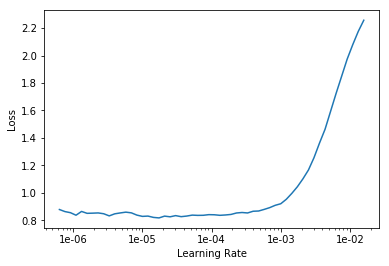

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(4, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.840384,0.885135,0.266145,01:27
1,0.800752,0.868464,0.256849,01:27
2,0.742928,0.864276,0.250978,01:28
3,0.713862,0.863077,0.255382,01:27


In [11]:
learn.save('stage-2')

In [12]:
classes = train_list.classes
classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [13]:
#这里首先定义了预测的类别，并且初始化了一个空的数据集用于预测，
#数据集定义了图片变化的尺寸为128，并且做了归一化
data2 = ImageDataBunch.single_from_classes("../input/", classes, tfms, size=128)

#使用上面定义的空数据集初始化resnet50网络，并且读取训练好的模型
learn2 = cnn_learner(data2, models.resnet50, model_dir="/tmp/model/").load('stage-2')

In [14]:
def getFileNameWithoutExtension(path):
    return path.split('\\').pop().split('/').pop().rsplit('.', 1)[0]

In [15]:
path_list = test_path.ls()
column = ['id'] + classes
# print(path_list)
df=pd.DataFrame(columns=column)
# df.head(5)
num = 0
for index,image_path in enumerate(path_list):
    if os.path.isfile(image_path) == False:
        continue
    img = open_image(image_path)
#     print(image)
    filename = getFileNameWithoutExtension(image_path.name)
#     print(index,filename)
    pred_class,pred_idx,outputs = learn2.predict(img)
    line = np.append([filename], np.array(outputs))
    df.loc[num] = line
    num += 1
#     break

df.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,7706f53709f6897699a862ecfc9d888d,2.282323e-06,2.1461667e-05,2.6354708e-05,7.3683636e-06,2.2146374e-05,2.2647077e-05,1.5487165e-05,2.256836e-05,3.502881e-05,7.4654476e-05,2.615328e-05,6.720191e-06,1.3279673e-05,1.664442e-05,0.00010799186,0.00019510335,0.00015557992,8.351334e-05,0.00037016167,4.4239918e-05,2.0840438e-05,6.1977703e-06,8.141347e-06,2.7240014e-05,9.652059e-06,0.00011238055,3.222045e-05,0.00079606305,9.194596e-06,2.280936e-05,1.6663757e-06,5.316899e-06,1.5414439e-06,0.00015859825,3.2507812e-06,1.8321352e-05,9.824222e-05,0.0007813439,3.520651e-05,...,0.14017212,3.9997747e-05,1.6483831e-05,9.417727e-05,4.7424586e-05,1.1529281e-06,0.00018361749,7.654261e-06,4.1943353e-05,3.3586857e-05,3.4802931e-06,2.5487354e-05,6.334683e-05,9.435644e-05,2.8152586e-05,0.00031850554,2.7045899e-05,1.4131449e-05,2.6021112e-06,7.603766e-05,7.688456e-06,0.02057173,1.8384379e-05,1.214295e-06,2.1485073e-05,1.8282751e-06,0.00022119157,4.231303e-06,0.00012252951,2.7693346e-07,5.3613985e-07,5.327535e-05,4.4748576e-06,3.870165e-05,5.591439e-06,8.628237e-06,8.256238e-06,3.4588502e-05,3.4010034e-05,1.9206736e-06
1,c89cace19e82b4c99b193a198bf75bdd,0.00017047647,6.908318e-05,0.00045600752,0.0013147885,0.0040949527,0.00047264522,0.0009834181,0.011476862,0.004677285,0.001888802,0.0017681576,1.3982595e-05,0.00030131073,0.0002961958,0.0061636874,0.0006594378,3.9658084e-05,0.0003793847,0.0004298668,0.00044080152,0.00024917236,0.0061001224,0.0005944227,0.00010496522,0.0030785205,0.0005935186,0.0006282859,0.0005863044,0.27881005,0.05844104,0.00092249323,0.0019030172,0.0006188403,0.00018879287,0.0007434548,0.0001495932,0.00084148144,0.0033190493,0.0005077123,...,0.00047518138,0.0008717252,0.00024765485,0.001862847,0.00024156373,0.00045899293,0.00022313834,0.002729164,0.002910707,0.10386368,0.037860952,0.0011450556,0.0002475747,0.0013749921,0.00062549964,0.00035647,0.00028564292,0.00012807465,0.0005531031,0.00030530096,0.00072219886,0.0004238011,0.00031368583,0.00031088173,0.0019430768,0.001759077,0.0005899212,0.002462423,5.7601115e-05,7.261512e-05,0.0046266546,0.000511517,0.13478388,0.0022522765,0.10755161,0.0010090178,0.00022431866,0.0194457,0.0006374586,0.0016268073
2,9461a7aa1d7c36c48cc981bb0ff6e45a,0.00019686224,4.2764543e-05,5.031946e-05,0.001095449,2.3292823e-05,1.2296143e-05,0.16170762,1.5041745e-05,9.843089e-06,2.8281682e-05,9.083145e-06,0.00030104158,7.955467e-05,7.5392505e-05,7.345349e-05,7.7557015e-06,8.93357e-06,6.550132e-05,2.0509828e-05,7.4953855e-06,2.4726462e-05,1.9295758e-05,0.00031524195,0.00026021304,3.2938897e-05,6.855275e-05,8.51089e-06,3.0818424e-05,1.0904568e-05,7.295068e-06,4.145536e-06,9.1578135e-05,0.00011165851,6.139944e-05,2.3127973e-06,0.0013196454,1.8238567e-05,9.856107e-06,0.00017399271,...,4.615603e-06,8.1238875e-05,2.4312905e-05,0.0008352705,7.902279e-05,0.0001514883,1.201215e-05,1.2007145e-05,6.5822724e-06,2.2239441e-05,3.2171636e-05,0

In [16]:
df.to_csv('submisson.csv', index=False)